# 06. Model selection

### 1. Implement a linear model

* return the weight parameters w = (w1, w2, ... , wP) and the intercept parameter w0 separately where:


$$ \hat{y}(\vec{w}, \vec{x}) = w_0 + w_1 x_1 + ... + w_p x_p$$


* check your returned coefficients with the built in `LinearRegression` class from the `sklearn` library, they should be within tolerance `1e-6`to each other


* use a generated regression dataset `from sklearn.dataset import make_regression` API with parameters `n_samples=1000` and `n_features=20`

### 2. Use of real data

* download the [Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) from UCI, the task includes understanding the dataset: naming the appropiate data fields, handling missing values, etc.
    
* fit a `LinearRegression` model with 5-fold cross-validation - compare training and testing scores (R^2 by default) for the different CV splits, print the mean score and its standard deviation

* find the best `Lasso` regression model with 5-fold grid search cross validation (`GridSearchCV`) on the parameters: `alpha, normalize, max_iter` and show the best parameter set


### 3. Shrinkage

* interpret Lasso model's findings based on its descriptive parameters by the shrinkage method described during the lecture (make a plot and check the names of the features that are not eliminated by the penalty parameter) on the data we have here (this is an explanatory data analysis problem, be to be creative)

* fit Ridge model and apply the shrinkage method as well, did you get what you expect?

* do you think normalization is needed here? If so, do not forget!

### 4. Subset selection

* Split the data to a training and test set and do recursive feature elimination until 10 remaining predictors with 5-fold cross-validated regressors (`RidgeCV`, `LassoCV`, `ElasticNetCV`) on the training set, plot their names and look up some of their meanings (recursive feature elimination is part of `sklearn` but you can do it with a for loop if you whish).

* Do all models provide the same descriptors? Check their performance on the test set! Plot all model predictions compared to the `y_test` on 3 different plots, which model seems to be the best?

### 5. ElasticNet penalty surface

* visualize the surface of the $ objective(\alpha, \beta) $ parameters corresponding to the L1 and L2 regularizations. Select the best possible combination of the hyper-parameters that minimize the objective (clue: `from scipy.optimize import minimize`)
    * this task is similar to what you've seen during class, just not for MSE vs. single penalty parameter but MSE vs. two penalty parameters $\alpha, \beta$

* interpret the findings! do you think linear models are powerful enough on this dataset?

# Preps

In [224]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge,RidgeCV,LassoCV,ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

from scipy.stats import tstd
from scipy.optimize import minimize

 # Task 1

In [2]:
def get_weights(x_mx,y_vec):
    """
    This function will calculate the weight parameters
    Arguments:
    X_mx = a matrix containing the x values
    y_vec = is a vector containing y values
    """
    
    np.c_[x_mx,np.ones(len(x_mx))]
    omegas = np.matmul(np.linalg.pinv(x_mx),y_vec)

    return omegas[:len(omegas)-1],omegas[len(omegas)-1]


In [3]:
SKLR = LinearRegression()

In [4]:
# Creating data for testing
x,y,coef = make_regression(n_samples = 1000,n_features = 20,coef = True)

In [5]:
# Calculating our result with sklrean linear regression modell and also with our own function
my_coefs,w0= get_weights(x,y)
SKLR.fit(x,y)
skl_coefs = SKLR.coef_
# This steps is just helps me to check the values easier
res = np.append(my_coefs,w0)

In [6]:
def check(res,official,error = 1e-6):
    """
    This function will compare the values between two lists
    error parameter is optional, default 1e-6
    """
    v_check = lambda x,y:abs(x-y) > error
    error_occured = False
    for e1,e2 in zip(res,official):
        if v_check(e1,e2): 
            error_occured = True
            print('Error while checking values \n')
    if not error_occured:
        print('Every value were in between the given error \n')

In [7]:
# Checking the values, everything is good so far
check(res,skl_coefs)
check(res, coef)

Every value were in between the given error 

Every value were in between the given error 



# Task 2

In [8]:
#From the original data, the names are in between line 76 and 203
names = open('communities.names','r').readlines()[75:203]
# Get rid of other parameters
names = list(map(lambda sr:sr.replace('@attribute ',''),names))
names = list(map(lambda sr:sr.replace('numeric\n',''),names))
names = list(map(lambda sr:sr.replace('string\n',''),names))


In [9]:
# Creating the dataframe with the given names
df = pd.read_csv('communities.data',names=names,na_values ="?")

In [10]:
"""
First I just wanted to get rid of all the columns, wich has more missing values than a few hundred
Later I've been told, that if I check the towns and the villigaes separetly it's more informative
Parsing the orriginal data into 2
"""
towns = df[df["LandArea "] >= 0.06 ]
villages = df[df["LandArea "] < 0.06 ]

#dropping the uninformative or useless columns
villages.dropna(axis = 1,thresh = len(villages)-300, inplace = True)
towns.dropna(axis = 1,thresh = len(towns)-300, inplace = True)
villages.dropna(axis = 0,inplace = True)

villages.drop("communityname ",axis = 1,inplace = True)
towns.drop("communityname ",axis = 1,inplace = True)

In [11]:
"""
Parsing the data's into x and y datasets
"""

x_town = towns[towns.columns[0:len(towns.columns)-1]]
y_town = towns[towns.columns[len(towns.columns)-1] ]

x_villages = villages[villages.columns[0:len(villages.columns)-1]]
y_villages = villages[villages.columns[len(villages.columns)-1] ]


In [12]:
# Executeing the cross validation
town_scores = cross_validate(LinearRegression(),X=x_town,y=y_town,cv = None,scoring ='r2',return_train_score = True)
village_scores = cross_validate(LinearRegression(),X=x_villages,y=y_villages,cv = None,scoring ='r2',return_train_score = True)

In [223]:
def scoreplot(data,name):
    """
    This function will plot the scores
    It takes tha dataset as an input
    And it requires a name for the plot names
    """
    plt.figure(figsize=(7,7))

    plt.title('Train scores of ' +name)
    plt.xlabel('X label')
    plt.ylabel('Values of scoreing')

    plt.plot(data['train_score'],label = "train score")
    plt.plot(data['test_score'],label = "test score")
    
    plt.legend()

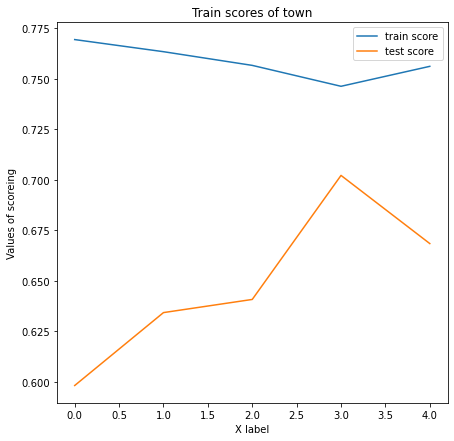

In [14]:
scoreplot(town_scores,'town')


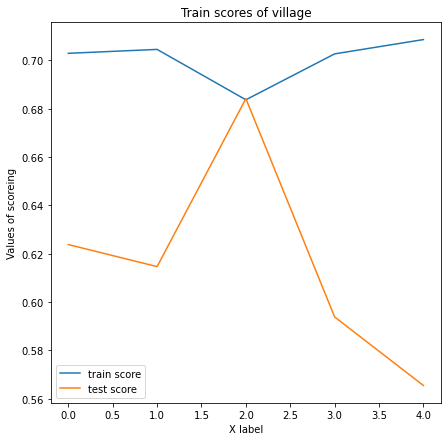

In [15]:
scoreplot(village_scores,'village')

In [16]:
def pr(name,x):
 print("The mean of " + name +" test scores is "+str(np.round(np.mean(x['test_score']),3)) )
 print('The standard deviation of ' + name +"test scores is " +str(np.round(tstd(x['test_score']),3)))
 print("The mean of " + name +" train scores is "+str(np.round(np.mean(x['train_score']),3)) )
 print('The standard deviation of ' + name +"train scores is "+ str(np.round(tstd(x['train_score']),3)))

In [17]:
pr('town',town_scores)
print('\n')
pr('village',village_scores)

The mean of town test scores is 0.649
The standard deviation of towntest scores is 0.039
The mean of town train scores is 0.758
The standard deviation of towntrain scores is 0.009


The mean of village test scores is 0.616
The standard deviation of villagetest scores is 0.044
The mean of village train scores is 0.7
The standard deviation of villagetrain scores is 0.01


In [18]:
# Searching for best hyperparameter via GridSearchCV
grid_search_result = GridSearchCV(Lasso(),{"alpha":np.linspace(-0.1,1.,20), "normalize":[True,False], "max_iter":[10,50,100,150]})
grid_search_result.fit(x_town,y_town)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([-0.1       , -0.04210526,  0.01578947,  0.07368421,  0.13157895,
        0.18947368,  0.24736842,  0.30526316,  0.36315789,  0.42105263,
        0.47894737,  0.53684211,  0.59473684,  0.65263158,  0.71052632,
        0.76842105,  0.82631579,  0.88421053,  0.94210526,  1.        ]),
                         'max_iter': [10, 50, 100, 150],
                         'normalize': [True, False]})

In [19]:
print('Best hyperparameters are:')
print(grid_search_result.best_params_)

Best hyperparameters are:
{'alpha': 0.015789473684210534, 'max_iter': 10, 'normalize': False}


# Task 3

In [130]:
def shrinkage(model,u_limit = 0.04):
    """
    This function will apply the shrinkage method on model
    It's only parameter, the model itself
    """
    all_coefs = []
    alphas = []

    for a in np.linspace(0.01,u_limit,40):
        alphas.append(a)
        l = model(alpha=a)
        l.fit(x_villages,y_villages)
        all_coefs.append(l.coef_)

    all_coeffs = np.array(all_coefs)
    return all_coeffs,alphas

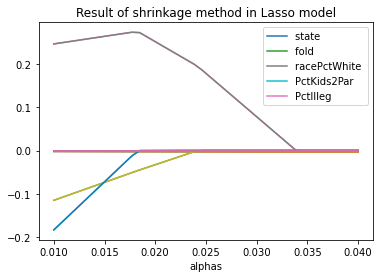

In [127]:
plt.title('Result of shrinkage method in Lasso model')
c1,alphas1 = shrinkage(Lasso)
for i,col in enumerate(x_town.columns):
    if c1[:,i].any() > 0.9:
        plt.plot(alphas1,c1[:,i],label = col)
    plt.plot(alphas1,c1[:,i])
    plt.xlabel('alphas')
plt.legend()
plt.show()

In [131]:
c_2,alphas_2 = shrinkage(Ridge,u_limit=0.3)

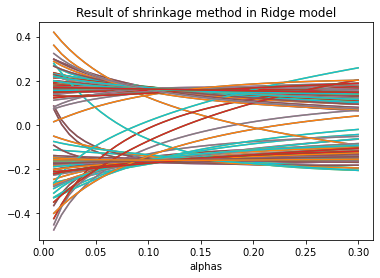

In [132]:
plt.title('Result of shrinkage method in Ridge model')
for i,col in enumerate(x_town.columns):
    normalized_c = c_2[:,i] / np.sqrt(np.sum(c_2[:,i]**2))
    plt.plot(alphas_2,normalized_c,label = col)
    plt.plot(alphas_2,normalized_c)
    plt.xlabel('alphas')
plt.show()
# Yes normalization would be fine here

# Task 4

In [152]:
# Splitting into 2 parts test and training dataset
x_train = x_town[::2]
y_train = y_town[::2]

x_test = x_town[1::2]
y_test = y_town[1::2]


In [186]:
def print_reamining_predictors(estimator,e_name):
    """
    This function will do the RFE then print, tha reamianing 10 predictors
    """
    selector = RFE(estimator,n_features_to_select=10)
    selector = selector.fit(x_train,y_train)
    print('The 10 remaining predictor after the RFE in ' + e_name+':' )
    for e in x_train.columns[selector.support_]:
        print("- " +e)
    return selector

In [212]:
las = print_reamining_predictors(LassoCV(),'LassoCV')
print('\n')
rg = print_reamining_predictors(RidgeCV(),'RidgeCV')
print('\n')
elast = print_reamining_predictors(ElasticNetCV(),'ElasticNetCV')

The 10 remaining predictor after the RFE in LassoCV:
- racepctblack 
- racePctAsian 
- agePct16t24 
- pctWPubAsst 
- PctKids2Par 
- PctIlleg 
- PctImmigRec5 
- PctLargHouseFam 
- HousVacant 
- PopDens 


The 10 remaining predictor after the RFE in RidgeCV:
- racepctblack 
- racePctWhite 
- pctWPubAsst 
- PctFam2Par 
- PctKids2Par 
- PctYoungKids2Par 
- PctIlleg 
- PctPersDenseHous 
- HousVacant 
- NumStreet 


The 10 remaining predictor after the RFE in ElasticNetCV:
- racePctWhite 
- agePct16t24 
- pctWPubAsst 
- PctKids2Par 
- PctWorkMom 
- PctIlleg 
- PctImmigRec5 
- HousVacant 
- PctHousOccup 
- NumStreet 


In [219]:
# Creating a varriable for the plots
x_label = np.linspace(0,len(y_test),len(y_test))

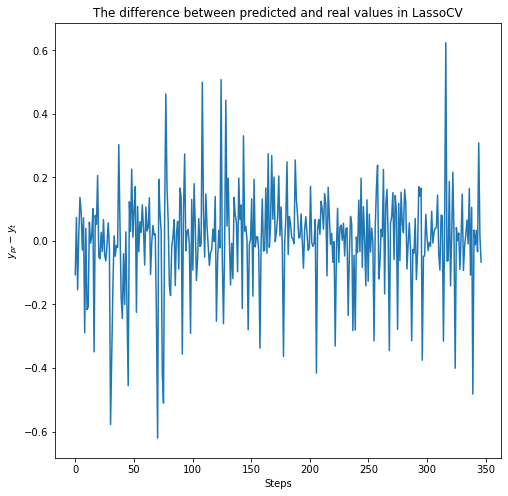

In [220]:
#Plotting the result of LassoCV's prediction
plt.figure(figsize=(8,8))
plt.title('The difference between predicted and real values in LassoCV')
plt.xlabel('Steps')
plt.ylabel('$y_{pr}-y_{t}$')
plt.plot(x_label,las.predict(x_test)-y_test)

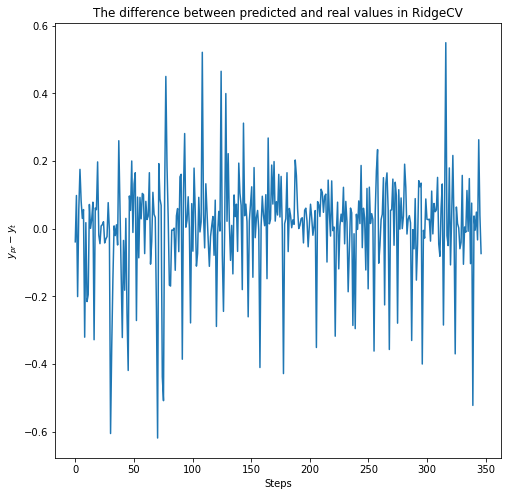

In [221]:
#Plotting the result of RidgeCV's predictions
plt.figure(figsize=(8,8))
plt.title('The difference between predicted and real values in RidgeCV')
plt.xlabel('Steps')
plt.ylabel('$y_{pr}-y_{t}$')
plt.plot(x_label,rg.predict(x_test)-y_test)


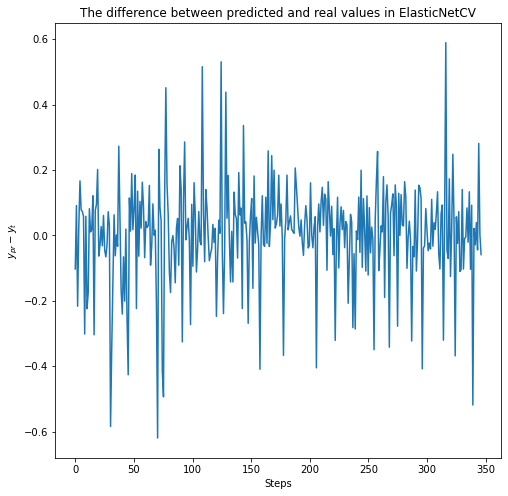

In [222]:
# plotting the result of ElasticNetCV's prediction
plt.figure(figsize=(8,8))
plt.title('The difference between predicted and real values in ElasticNetCV')
plt.xlabel('Steps')
plt.ylabel('$y_{pr}-y_{t}$')
plt.plot(x_label,elast.predict(x_test)-y_test)

The results of these 3 model are quite similar, by watching i could not decide wich performs better

# Task 5

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 